## Capstone project: The battle of neighbourhoods

In [1]:
import pandas as pd
import numpy as np
import urllib.request
from pandas.io.html import read_html
import geocoder 
import requests
from bs4 import BeautifulSoup
import re

### URL 

In [2]:
## URL to extract City neighbourhood information
urlL = "https://en.wikipedia.org/wiki/List_of_London_boroughs"
urlP = "https://en.wikipedia.org/wiki/Arrondissements_of_Paris"
pageLondon = urllib.request.urlopen(urlL)
pageParis = urllib.request.urlopen(urlP)
wikitablesL = read_html(urlL,  attrs={"class":"wikitable"})
print ("Extracted {num} wikitables from London Wikipedia".format(num=len(wikitablesL)))
wikitablesP = read_html(urlP,  attrs={"class":"wikitable"})
print ("Extracted {num} wikitables from Paris Wikipedia".format(num=len(wikitablesP)))
dfP = wikitablesP[0]
dfL0 = wikitablesL[0]
dfL1 = wikitablesL[1]

Extracted 2 wikitables from London Wikipedia
Extracted 1 wikitables from Paris Wikipedia


In [3]:
## Request & response 
# Session helps to object allows you to persist certain parameters across requests
s = requests.Session()
responseL = s.get(urlL,timeout=10)
responseP = s.get(urlP,timeout=5)

## Data wrangling with Beautiful soup

### First we extract data from London wikipedia

In [4]:
# parse response content to html
html_content = responseL.text
soupL = BeautifulSoup(html_content, 'html.parser')
print('Lets extract:',soupL.title.string)
# find all the tables in the html
all_tablesL=soupL.find_all('table', class_='sortable')
# get all the tables to scrap
tableL0 = all_tablesL[0]
tableL1 = all_tablesL[1]

Lets extract: List of London boroughs - Wikipedia


In [5]:
## Lets look at one of the London wikipedia tables (As they are similar)
# Number of columns in the table
for row in tableL0.findAll("tr"):
    cellsL = row.findAll('td')
# number of rows in the table including header
rowsL = tableL0.findAll("tr")
print('columns:',len(cellsL),'rows:',len(rowsL))
# Get table header atrributes
headerL = [th.text.rstrip() for th in rowsL[0].find_all("th")]
print('column names for London information table:',headerL)

columns: 10 rows: 33
column names for London information table: ['Borough', 'Inner', 'Status', 'Local authority', 'Political control', 'Headquarters', 'Area (sq mi)', 'Population (2013 est)[1]', 'Co-ordinates', ' Nr. in map']


In [6]:
def scrapeLondonTable(table):
    c1=[]
    c2=[]
    c3=[]
    c4=[]
    c5=[]
    c6=[]
    c7=[]
    c8=[]
    c9=[]
    c10=[]
    c11=[]

    for row in table.findAll("tr"):
        cellsL = row.findAll('td')
        if len(cellsL)==10: #Only extract table body not heading
            c1.append(cellsL[0].find('a').text)
            c2.append(cellsL[1].find(text=True))   
            c3.append(cellsL[2].find(text=True))
            c4.append(cellsL[3].find(text=True))
            c5.append(cellsL[4].find(text=True))
            c6.append(cellsL[5].find(text=True))
            c7.append(cellsL[6].find(text=True))
            c8.append(cellsL[7].find(text=True))
            c9.append(cellsL[8].find('span',{'class': 'geo'}))
            c10.append(cellsL[9].find(text=True))
    # create a dictionary
    d = dict([(x,0) for x in headerL])
    # append dictionary with corresponding data list.
    d['Borough'] = c1
    d['Inner']= c2
    d['Status']=c3
    d['Local authority']=c4
    d['Political control']=c5
    d['Headquarters']=c6
    d['Area (sq mi)']=c7
    d['Population (2013 est)[1]']=c8
    d['Co-ordinates']=c9
    d[' Nr. in map']=c10
    # convert dict to DataFrame
    dfL_table = pd.DataFrame(d)
    ## convert Area units to kms^2
    #dfL["Area"] = 2.59 * (pd.to_numeric(dfL["Area"]))
    Latitude = []
    Longitude = []
    for i in range(len(dfL_table)):
        locationSplit = dfL_table['Co-ordinates'].iloc[i].getText().split("; ") 
        Latitude.append(locationSplit[0])
        Longitude.append(locationSplit[1])
    dfL_table['Latitude'] = Latitude
    dfL_table['Longitude'] = Longitude
    dfL_table.drop(['Inner','Status','Local authority','Political control','Headquarters','Co-ordinates'],axis=1,inplace=True)
    dfL = dfL_table.rename(columns={'Area (sq mi)': 'Area', 'Population (2013 est)[1]': 'Population',' Nr. in map':'District Number'})
    dfL['District Number']  = dfL['District Number'].astype(int)
    for i in range(len(dfL)):
        dfL['Area'].iloc[i] = float(re.findall(r'[\d\.\d]+', dfL['Area'].iloc[i])[0])
        dfL['Population'].iloc[i] = int(dfL['Population'].iloc[i].replace(',',''))
    return dfL

In [7]:
tableL = pd.concat([scrapeLondonTable(tableL0), scrapeLondonTable(tableL1)], ignore_index=True)
## re-arrange districts from center to outer London
tableL = tableL.sort_values(by=['District Number'])  
tableL = tableL.reset_index(drop=True)
tableL.head()

/Users/sahuja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,Borough,Area,Population,District Number,Latitude,Longitude
0,City of London,1.12,7000,1,51.5155,-0.0922
1,Westminster,8.29,226841,2,51.4973,-0.1372
2,Kensington and Chelsea,4.68,155594,3,51.5020,-0.1947
3,Hammersmith and Fulham,6.33,178685,4,51.4927,-0.2339
4,Wandsworth,13.23,310516,5,51.4567,-0.1910


### Secondly extracting data from Paris wikipedia

In [8]:
# parse response content to html
html_content2 = responseP.text
soupP = BeautifulSoup(html_content2, 'html.parser')
print('Lets extract:',soupP.title.string)
# find all the tables in the html
all_tablesP=soupP.find_all('table', class_='sortable')
# get all the tables to scrap
tableP = all_tablesP[0]

Lets extract: Arrondissements of Paris - Wikipedia


In [9]:
## Lets look at the Paris wikipedia tables
# Number of columns in the table
for row in tableP.findAll("tr"):
    cellsP = row.findAll('td')
# number of rows in the table including header
rowsP = tableP.findAll("tr")
print('columns:',len(cellsP),'rows:',len(rowsP))
# Get table header atrributes
headerP = [th.text.rstrip() for th in rowsP[0].find_all("th")]
print('column names for Paris information table:',headerP)

columns: 8 rows: 18
column names for Paris information table: ['Arrondissement (R for Right Bank, L for Left Bank)', 'Name', 'Area (km2)', 'Population(2017 estimate)', 'Density (2017)(inhabitants per km2)', 'Peak of population', 'Mayor', '2020-2026']


#### Dataframe Paris

In [10]:
def scrapeParisTable(table):
    c1=[]
    c2=[]
    c3=[]
    c4=[]
    c5=[]
    c6=[]
    c7=[]
    c8=[]

    for row in table.findAll("tr"):
        cells = row.findAll('td')
        if len(cells)==8: #Only extract table body not heading
            c1.append(cells[0].find('a').text)
            c2.append(cells[1].find(text=True))   
            c3.append(cells[2].find(text=True))
            c4.append(cells[3].find(text=True))
            c5.append(cells[4].find(text=True))
            c6.append(cells[5].find(text=True))
            c7.append(cells[6].find('a').text)
            c8.append(cells[7].find(text=True))

    # create a dictionary
    d1 = dict([(x,0) for x in headerP])
    # append dictionary with corresponding data list.
    d1['Arrondissement (R for Right Bank, L for Left Bank)'] = c1
    d1['Name']= c2
    d1['Area (km2)']=c3
    d1['Population(2017 estimate)']=c4
    d1['Density (2017)(inhabitants per km2)']=c5
    d1['Peak of population']=c6
    d1['Mayor']=c7
    d1['2020-2026']=c8
    # convert dict to DataFrame
    dfP_table = pd.DataFrame(d1)

    dfP_table.drop(['Density (2017)(inhabitants per km2)','Peak of population','Mayor','2020-2026'],axis=1,inplace=True)
    dfP = dfP_table.rename(columns={'Name': 'Borough','Area (km2)':'Area','Population(2017 estimate)':'Population','Arrondissement (R for Right Bank, L for Left Bank)':'District Number'})
    ## Extract the number from the string pattern
    for i in range(len(dfP)):
        dfP['District Number'].iloc[i] = int(re.search(r'\d+', dfP['District Number'].iloc[i])[0])      
        dfP['Area'].iloc[i] = float(re.findall(r'[\d\.\d]+', dfP['Area'].iloc[i])[0])
        dfP['Population'].iloc[i] = int(dfP['Population'].iloc[i].replace(',',''))
    ## Extract co-ordinates from file
    dfGeo_Paris = pd.read_csv('Paris_Geospatial_Coordinates.csv')
    lat_coords = []
    lng_coords = []
    for (index, row) in dfP['District Number'].iteritems():
        postalcode = 75000 + row ## Paris postal codes go from 75001-75020
        # loop until you get the coordinates
        for (index1, row1) in dfGeo_Paris['Postal Code'].iteritems():
            if(row1 == postalcode):
                lat_coords.append(dfGeo_Paris['Latitude'].iloc[index1])
                lng_coords.append(dfGeo_Paris['Longitude'].iloc[index1])            
    dfP['Latitude'] = lat_coords
    dfP['Longitude'] = lng_coords
    return dfP

In [11]:
tableP = scrapeParisTable(tableP)
tableP.head(5)

,District Number,Borough,Area,Population,Latitude,Longitude
0,1,"Louvre, Bourse, Temple, Hôtel-de-Ville",5.59,100196,48.860000,2.341110
1,5,Panthéon,2.541,59631,48.847220,2.344440
2,6,Luxembourg,2.154,41976,48.850531,2.332233
3,7,Palais-Bourbon,4.088,52193,48.859170,2.312780
4,8,Élysée,3.881,37368,48.874170,2.311110


## Data visualization using folium maps 

In [12]:
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
from folium import plugins

In [13]:
addressL = 'London, United Kingdom'

geolocator = Nominatim(user_agent="tr_explorer")
location = geolocator.geocode(addressL)
latitude_London = location.latitude
longitude_London = location.longitude
print('The geograpical coordinates of London city are {}, {}.'.format(latitude_London, longitude_London))

The geograpical coordinates of London city are 51.5073219, -0.1276474.


In [14]:
## Map of London as per Boroughs latitude and longitude values
map_London = folium.Map(location=[latitude_London, longitude_London], zoom_start=10)
## add markers to map mapped according to population density of each Borough per km^2
for i in range(0,len(tableL)):
    for lat, lng, borough, pop in zip(tableL['Latitude'], tableL['Longitude'], tableL['Borough'], tableL['Population']/(tableL['Area']*2.59)):
        label = '{},{}'.format(borough,int(pop))
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=pop/1000,
            popup=label,
            color='blue',
            icon=folium.Icon(),
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_London)
map_London

In [15]:
addressP = 'Paris, France'

geolocator = Nominatim(user_agent="tr_explorer")
locationP = geolocator.geocode(addressP)
latitude_Paris = locationP.latitude
longitude_Paris = locationP.longitude
print('The geograpical coordinates of Paris city are {}, {}.'.format(latitude_Paris, longitude_Paris))

The geograpical coordinates of Paris city are 48.8566969, 2.3514616.


In [16]:
## Map of Paris as per Boroughs latitude and longitude values
map_Paris = folium.Map(location=[latitude_Paris, longitude_Paris], zoom_start=12)
## add markers to map mapped according to population density of each Borough per km^2
for i in range(0,len(tableP)):
    for lat, lng, borough, pop in zip(tableP['Latitude'], tableP['Longitude'], tableP['Borough'],tableL['Population']/(tableL['Area'])):
        labelP = '{}, {}'.format(borough,int(pop))
        labelP = folium.Popup(labelP, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=pop/2000,
            popup=labelP,
            color='blue',
            icon=folium.Icon(),
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_Paris)     
map_Paris

## Foursquare data

In [17]:
CLIENT_ID = 'EO0KBHDR2ZELDZ45YPHB00KM4NNKRS0A53NT1VKOKIME1URK' # your Foursquare ID
CLIENT_SECRET = '5AGXFUFRK5P4PO0KMDDFOTDWM11XYDJA0HERBX3UKTZHT5QH' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: EO0KBHDR2ZELDZ45YPHB00KM4NNKRS0A53NT1VKOKIME1URK
CLIENT_SECRET:5AGXFUFRK5P4PO0KMDDFOTDWM11XYDJA0HERBX3UKTZHT5QH


### Extracting venues from Foursquare

In [18]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Borough Latitude', 
                  'Borough Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [19]:
print("Getting venues inside the following Boroughs of London:")
London_venues = getNearbyVenues(names=tableL['Borough'],
                                   latitudes=tableL['Latitude'],
                                   longitudes=tableL['Longitude']
                                  )
print(" ")
print("Getting venues inside the following Arrondissements of Paris:")
Paris_venues = getNearbyVenues(names=tableP['Borough'],
                                   latitudes=tableP['Latitude'],
                                   longitudes=tableP['Longitude']
                                  )

Getting venues inside the following Boroughs of London:
City of London
Westminster
Kensington and Chelsea
Hammersmith and Fulham
Wandsworth
Lambeth
Southwark
Tower Hamlets
Hackney
Islington
Camden
Brent
Ealing
Hounslow
Richmond upon Thames
Kingston upon Thames
Merton
Sutton
Croydon
Bromley
Lewisham
Greenwich
Bexley
Havering
Barking and Dagenham
Redbridge
Newham
Waltham Forest
Haringey
Enfield
Barnet
Harrow
Hillingdon
 
Getting venues inside the following Arrondissements of Paris:
Louvre, Bourse, Temple, Hôtel-de-Ville
Panthéon
Luxembourg
Palais-Bourbon
Élysée
Opéra
Entrepôt
Popincourt
Reuilly
Gobelins
Observatoire
Vaugirard
Passy
Batignolles-Monceau
Butte-Montmartre
Buttes-Chaumont
Ménilmontant


In [20]:
print(London_venues.shape)
print('There are {} uniques venue categories in London.'.format(len(London_venues['Venue Category'].unique())))

(1536, 7)
There are 224 uniques venue categories in London.


In [21]:
print(Paris_venues.shape)
print('There are {} uniques venue categories in Paris.'.format(len(Paris_venues['Venue Category'].unique())))

(1101, 7)
There are 179 uniques venue categories in Paris.


In [44]:
## Picking major districts inside center of London and Paris respectively
districtsL = ['City of London','Westminster','Kensington and Chelsea','Hammersmith and Fulham', 'Wandsworth']
districtsP = ['Louvre, Bourse, Temple, Hôtel-de-Ville', 'Panthéon', 'Luxembourg', 'Palais-Bourbon', 'Élysée']

def nearbyvenues_count(venues_df, district):
    venues_count = venues_df
    venues_count = venues_count.rename(columns={'Venue Category': 'Category'})
    venues_count = venues_count.groupby(['Borough']).Category.value_counts().to_frame("Counts")
    fig, ax = plt.subplots(1,1,figsize=(20, 7)) 
    fig.subplots_adjust(left=0.115, right=0.88)
    venues_plot =  venues_count['Counts'].loc[district][:10].head(10) 
    pos = np.arange(len(venues_plot))
    ax.set_title(district,size=20)
    freqchart = ax.barh(pos, venues_plot,align='center',height=0.5,tick_label=venues_plot.index)
    
    return freqchart 

<BarContainer object of 10 artists>

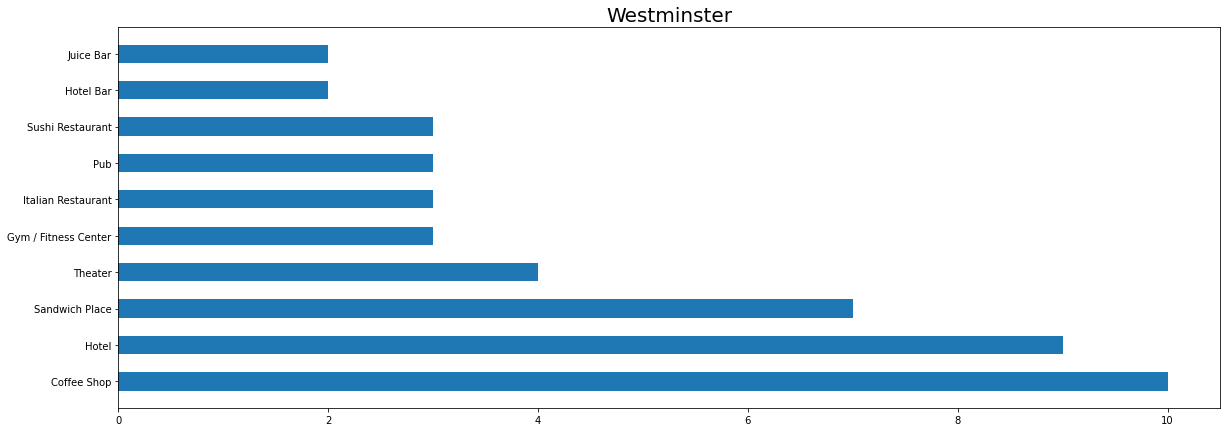

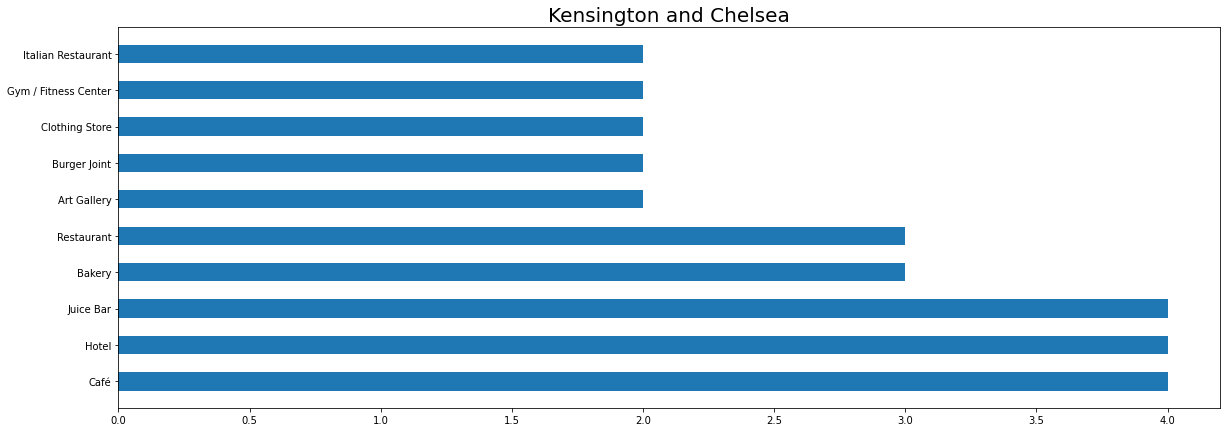

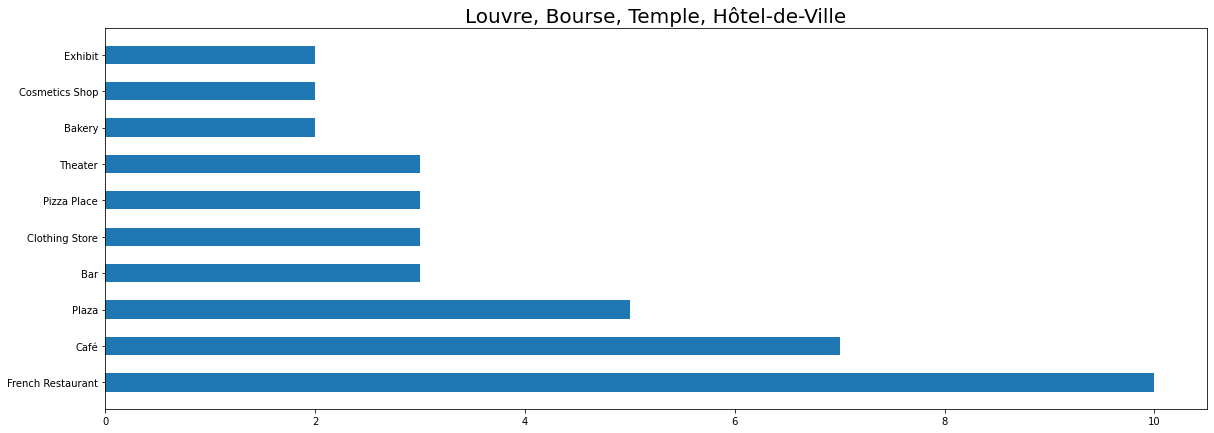

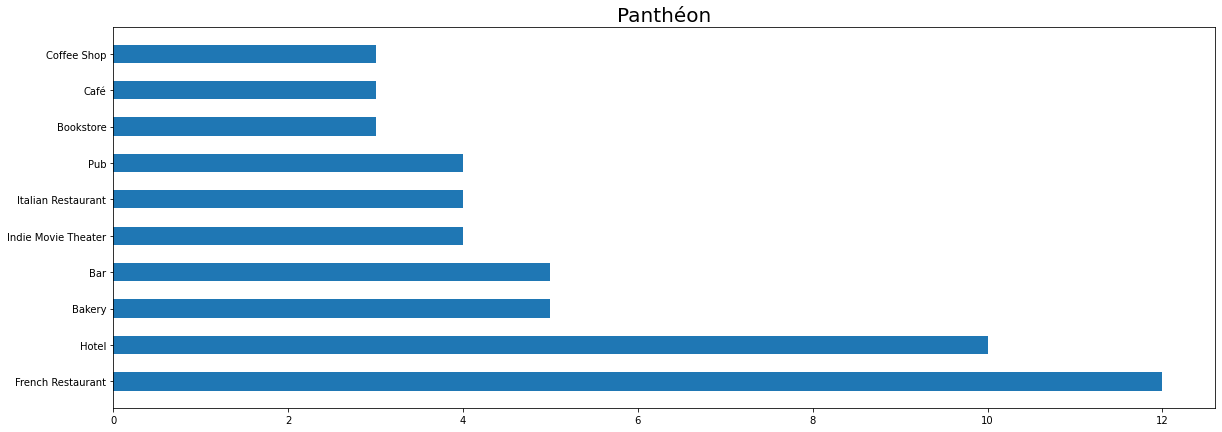

In [45]:
## Frequency bar chart for Boroughs from either city
nearbyvenues_count(London_venues, districtsL[1])
nearbyvenues_count(London_venues, districtsL[2])
nearbyvenues_count(Paris_venues, districtsP[0])
nearbyvenues_count(Paris_venues, districtsP[1])

### Categorizing venues into pandas columns

In [24]:
# one hot encoding
London_onehot = pd.get_dummies(London_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
London_onehot['Borough'] = London_venues['Borough'] 

# move neighborhood column to the first column
fixed_columns = [London_onehot.columns[-1]] + list(London_onehot.columns[:-1])
London_onehot = London_onehot[fixed_columns]

London_onehot.head()

,Borough,African Restaurant,Airport,Airport Lounge,Airport Service,American Restaurant,Antique Shop,Argentinian Restaurant,Art Gallery,Art Museum,...,Used Bookstore,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio
0,City of London,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,City of London,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,City of London,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,City of London,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,City of London,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
London_grouped = London_onehot.groupby('Borough').mean().reset_index()

In [26]:
# one hot encoding
Paris_onehot = pd.get_dummies(Paris_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Paris_onehot['Borough'] = Paris_venues['Borough'] 

# move neighborhood column to the first column
fixed_columns = [Paris_onehot.columns[-1]] + list(Paris_onehot.columns[:-1])
Paris_onehot = Paris_onehot[fixed_columns]

Paris_onehot.head()

,Borough,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Bagel Shop,...,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,"Louvre, Bourse, Temple, Hôtel-de-Ville",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Louvre, Bourse, Temple, Hôtel-de-Ville",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Louvre, Bourse, Temple, Hôtel-de-Ville",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Louvre, Bourse, Temple, Hôtel-de-Ville",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Louvre, Bourse, Temple, Hôtel-de-Ville",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
Paris_grouped = Paris_onehot.groupby('Borough').mean().reset_index()

In [28]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [29]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe for London
Londonboroughs_venues_sorted = pd.DataFrame(columns=columns)
Londonboroughs_venues_sorted['Borough'] = London_grouped['Borough']

for ind in np.arange(London_grouped.shape[0]):
    Londonboroughs_venues_sorted.iloc[ind, 1:] = return_most_common_venues(London_grouped.iloc[ind, :], num_top_venues)

Londonboroughs_venues_sorted.head()

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barking and Dagenham,Pool,Golf Course,Bus Station,Supermarket,Martial Arts Dojo,Park,Gym / Fitness Center,Fish Market,Film Studio,Field
1,Barnet,Café,Bus Stop,Business Service,Yoga Studio,Fried Chicken Joint,Food Court,Flea Market,Fish Market,Film Studio,Field
2,Bexley,Coffee Shop,Pub,Clothing Store,Fast Food Restaurant,Pharmacy,Supermarket,Portuguese Restaurant,Bakery,Italian Restaurant,Furniture / Home Store
3,Brent,Hotel,Coffee Shop,Clothing Store,Bar,Sporting Goods Shop,Grocery Store,Italian Restaurant,Burger Joint,Indian Restaurant,Sandwich Place
4,Bromley,Coffee Shop,Clothing Store,Burger Joint,Pizza Place,Gym / Fitness Center,Bar,Fast Food Restaurant,Café,Sandwich Place,Furniture / Home Store


In [30]:
# create a new dataframe for Paris
Parisboroughs_venues_sorted = pd.DataFrame(columns=columns)
Parisboroughs_venues_sorted['Borough'] = Paris_grouped['Borough']

for ind in np.arange(Paris_grouped.shape[0]):
    Parisboroughs_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Paris_grouped.iloc[ind, :], num_top_venues)

Parisboroughs_venues_sorted.head()

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Batignolles-Monceau,French Restaurant,Italian Restaurant,Bakery,Hotel,Bistro,Pastry Shop,Yoga Studio,Diner,Restaurant,Concert Hall
1,Butte-Montmartre,French Restaurant,Bar,Hotel,Gastropub,Pizza Place,Italian Restaurant,Restaurant,Café,Seafood Restaurant,Burger Joint
2,Buttes-Chaumont,French Restaurant,Supermarket,Hotel,Lebanese Restaurant,Pool,Bar,Italian Restaurant,Food & Drink Shop,Brasserie,Restaurant
3,Entrepôt,French Restaurant,Bistro,Pizza Place,Bakery,Japanese Restaurant,Indian Restaurant,Breakfast Spot,Bar,Café,Hotel
4,Gobelins,Hotel,Thai Restaurant,French Restaurant,Vietnamese Restaurant,Bar,Bakery,Italian Restaurant,Asian Restaurant,Indian Restaurant,Creperie


### Clustering analysis of neighbourhoods. Using k-means, clustering neighbourhoods into categories.

In [31]:
# Clustering London Boroughs first
# set number of clusters
kclustersL = 3

London_grouped_clustering = London_grouped.drop('Borough', 1)

# run k-means clustering
kmeansL = KMeans(n_clusters=kclustersL, random_state=0).fit(London_grouped_clustering)

# check cluster labels generated for each row in the dataframe
print(kmeansL.labels_[0:10])

# add clustering labels
Londonboroughs_venues_sorted.insert(0, 'Cluster Labels', kmeansL.labels_)

London_merged = tableL

# merge London_grouped with London_data to add latitude/longitude for each neighborhood
London_merged = London_merged.join(Londonboroughs_venues_sorted.set_index('Borough'), on='Borough')

London_merged.head() # check the last columns!

[1 2 1 1 1 1 1 1 1 1]


,Borough,Area,Population,District Number,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,City of London,1.12,7000,1,51.5155,-0.0922,1,Coffee Shop,Gym / Fitness Center,Steakhouse,Wine Bar,Scenic Lookout,Hotel,Clothing Store,French Restaurant,Art Gallery,Yoga Studio
1,Westminster,8.29,226841,2,51.4973,-0.1372,1,Coffee Shop,Hotel,Sandwich Place,Theater,Pub,Gym / Fitness Center,Italian Restaurant,Sushi Restaurant,Hotel Bar,Juice Bar
2,Kensington and Chelsea,4.68,155594,3,51.5020,-0.1947,1,Juice Bar,Hotel,Café,Restaurant,Bakery,Art Gallery,Burger Joint,Italian Restaurant,Clothing Store,Pub
3,Hammersmith and Fulham,6.33,178685,4,51.4927,-0.2339,1,Pub,Café,Indian Restaurant,Italian Restaurant,Gastropub,Coffee Shop,Hotel,Clothing Store,Bus Stop,Vietnamese Restaurant
4,Wandsworth,13.23,310516,5,51.4567,-0.1910,1,Clothing Store,Coffee Shop,Pub,Breakfast Spot,Supermarket,Indian Restaurant,Gym / Fitness Center,Gift Shop,Restaurant,Stationery Store


In [32]:
# create map
map_clustersL = folium.Map(location=[latitude_London, longitude_London], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclustersL)
ys = [i + x + (i*x)**2 for i in range(kclustersL)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(London_merged['Latitude'], London_merged['Longitude'], London_merged['Borough'], London_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clustersL)
       
map_clustersL

In [33]:
London_merged.loc[London_merged['Cluster Labels'] == 0, London_merged.columns[[1] + list(range(5, London_merged.shape[1]))]]

,Area,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,21.61,-0.3680,0,Metro Station,Park,Café,Bed & Breakfast,Yoga Studio,English Restaurant,Food Court,Flea Market,Fish Market,Film Studio


In [34]:
London_merged.loc[London_merged['Cluster Labels'] == 1, London_merged.columns[[1] + list(range(5, London_merged.shape[1]))]]

,Area,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1.12,-0.0922,1,Coffee Shop,Gym / Fitness Center,Steakhouse,Wine Bar,Scenic Lookout,Hotel,Clothing Store,French Restaurant,Art Gallery,Yoga Studio
1,8.29,-0.1372,1,Coffee Shop,Hotel,Sandwich Place,Theater,Pub,Gym / Fitness Center,Italian Restaurant,Sushi Restaurant,Hotel Bar,Juice Bar
2,4.68,-0.1947,1,Juice Bar,Hotel,Café,Restaurant,Bakery,Art Gallery,Burger Joint,Italian Restaurant,Clothing Store,Pub
3,6.33,-0.2339,1,Pub,Café,Indian Restaurant,Italian Restaurant,Gastropub,Coffee Shop,Hotel,Clothing Store,Bus Stop,Vietnamese Restaurant
4,13.23,-0.1910,1,Clothing Store,Coffee Shop,Pub,Breakfast Spot,Supermarket,Indian Restaurant,Gym / Fitness Center,Gift Shop,Restaurant,Stationery Store
5,10.36,-0.1163,1,Caribbean Restaurant,Coffee Shop,Pub,Market,Beer Bar,Pizza Place,Gym / Fitness Center,Mexican Restaurant,Indian Restaurant,Restaurant
6,11.14,-0.0804,1,Coffee Shop,Pub,Scenic Lookout,Cocktail Bar,Restaurant,Bar,French Restaurant,Italian Restaurant,Indian Restaurant,Hotel
7,7.63,-0.0059,1,Hotel,Italian Restaurant,Coffee Shop,Sandwich Place,Intersection,Boat or Ferry,Gym / Fitness Center,Grocery Store,Light Rail Station,Outdoor Sculpture
8,7.36,-0.0553,1,Pub,Bakery,Coffee Shop,Café,Brewery,Cocktail Bar,Modern European Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Hotel
9,5.74,-0.1022,1,Pub,Bakery,Park,Ice Cream Shop,Burger Joint,French Restaurant,Theater,Boutique,Yoga Studio,Spa


In [35]:
London_merged.loc[London_merged['Cluster Labels'] == 2, London_merged.columns[[1] + list(range(5, London_merged.shape[1]))]]

,Area,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
30,33.49,-0.1517,2,Café,Bus Stop,Business Service,Yoga Studio,Fried Chicken Joint,Food Court,Flea Market,Fish Market,Film Studio,Field


In [36]:
# Clustering Paris Boroughs first
# set number of clusters
kclustersP = 3

Paris_grouped_clustering = Paris_grouped.drop('Borough', 1)

# run k-means clustering
kmeansP = KMeans(n_clusters=kclustersP, random_state=0).fit(Paris_grouped_clustering)

# check cluster labels generated for each row in the dataframe
print(kmeansP.labels_[0:10])

# add clustering labels
Parisboroughs_venues_sorted.insert(0, 'Cluster Labels', kmeansP.labels_)

Paris_merged = tableP

# merge Paris_grouped with Paris_data to add latitude/longitude for each neighborhood
Paris_merged = Paris_merged.join(Parisboroughs_venues_sorted.set_index('Borough'), on='Borough')

Paris_merged.head() # check the last columns!

[1 0 0 1 2 1 1 1 0 0]


,District Number,Borough,Area,Population,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,"Louvre, Bourse, Temple, Hôtel-de-Ville",5.59,100196,48.860000,2.341110,1,French Restaurant,Café,Plaza,Clothing Store,Bar,Theater,Pizza Place,Hotel,Restaurant,Tea Room
1,5,Panthéon,2.541,59631,48.847220,2.344440,2,French Restaurant,Hotel,Bar,Bakery,Indie Movie Theater,Italian Restaurant,Pub,Coffee Shop,Bookstore,Plaza
2,6,Luxembourg,2.154,41976,48.850531,2.332233,1,French Restaurant,Italian Restaurant,Plaza,Garden,Wine Bar,American Restaurant,Tailor Shop,Café,Pastry Shop,Chocolate Shop
3,7,Palais-Bourbon,4.088,52193,48.859170,2.312780,0,French Restaurant,Hotel,Italian Restaurant,Plaza,Café,History Museum,Historic Site,Bakery,Bistro,Beer Garden
4,8,Élysée,3.881,37368,48.874170,2.311110,0,French Restaurant,Hotel,Bakery,Italian Restaurant,Art Gallery,Salad Place,Middle Eastern Restaurant,Hotel Bar,Café,Supermarket


In [37]:
# create map
map_clustersP = folium.Map(location=[latitude_Paris, longitude_Paris], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclustersP)
ys = [i + x + (i*x)**2 for i in range(kclustersP)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Paris_merged['Latitude'], Paris_merged['Longitude'], Paris_merged['Borough'], Paris_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clustersP)
       
map_clustersP

In [38]:
Paris_merged.loc[Paris_merged['Cluster Labels'] == 0, Paris_merged.columns[[1] + list(range(5, Paris_merged.shape[1]))]]

,Borough,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Palais-Bourbon,2.312780,0,French Restaurant,Hotel,Italian Restaurant,Plaza,Café,History Museum,Historic Site,Bakery,Bistro,Beer Garden
4,Élysée,2.311110,0,French Restaurant,Hotel,Bakery,Italian Restaurant,Art Gallery,Salad Place,Middle Eastern Restaurant,Hotel Bar,Café,Supermarket
5,Opéra,2.336967,0,French Restaurant,Hotel,Bistro,Bar,Coffee Shop,Wine Bar,Japanese Restaurant,Salad Place,Burger Joint,Cocktail Bar
10,Observatoire,2.326889,0,French Restaurant,Italian Restaurant,Bar,Hotel,Wine Shop,Vietnamese Restaurant,Bakery,Bistro,Latin American Restaurant,Southwestern French Restaurant
14,Butte-Montmartre,2.344447,0,French Restaurant,Bar,Hotel,Gastropub,Pizza Place,Italian Restaurant,Restaurant,Café,Seafood Restaurant,Burger Joint
15,Buttes-Chaumont,2.381822,0,French Restaurant,Supermarket,Hotel,Lebanese Restaurant,Pool,Bar,Italian Restaurant,Food & Drink Shop,Brasserie,Restaurant


In [39]:
Paris_merged.loc[Paris_merged['Cluster Labels'] == 1, Paris_merged.columns[[1] + list(range(5, Paris_merged.shape[1]))]]

,Borough,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Louvre, Bourse, Temple, Hôtel-de-Ville",2.341110,1,French Restaurant,Café,Plaza,Clothing Store,Bar,Theater,Pizza Place,Hotel,Restaurant,Tea Room
2,Luxembourg,2.332233,1,French Restaurant,Italian Restaurant,Plaza,Garden,Wine Bar,American Restaurant,Tailor Shop,Café,Pastry Shop,Chocolate Shop
6,Entrepôt,2.357853,1,French Restaurant,Bistro,Pizza Place,Bakery,Japanese Restaurant,Indian Restaurant,Breakfast Spot,Bar,Café,Hotel
7,Popincourt,2.379306,1,French Restaurant,Café,Wine Bar,Cocktail Bar,Italian Restaurant,Bistro,Supermarket,Restaurant,Pastry Shop,Bar
12,Passy,2.276489,1,French Restaurant,Bakery,Hotel,Café,Restaurant,Japanese Restaurant,Sandwich Place,Bus Stop,Spa,Garden
13,Batignolles-Monceau,2.307839,1,French Restaurant,Italian Restaurant,Bakery,Hotel,Bistro,Pastry Shop,Yoga Studio,Diner,Restaurant,Concert Hall
16,Ménilmontant,2.399050,1,French Restaurant,Bar,Bakery,Café,Bistro,Plaza,Japanese Restaurant,Italian Restaurant,Restaurant,Park


In [40]:
Paris_merged.loc[Paris_merged['Cluster Labels'] == 2, Paris_merged.columns[[1] + list(range(5, Paris_merged.shape[1]))]]

,Borough,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Panthéon,2.344440,2,French Restaurant,Hotel,Bar,Bakery,Indie Movie Theater,Italian Restaurant,Pub,Coffee Shop,Bookstore,Plaza
8,Reuilly,2.388183,2,Hotel,Bistro,Chinese Restaurant,French Restaurant,Supermarket,Health Food Store,Garden,Furniture / Home Store,Café,Sandwich Place
9,Gobelins,2.355560,2,Hotel,Thai Restaurant,French Restaurant,Vietnamese Restaurant,Bar,Bakery,Italian Restaurant,Asian Restaurant,Indian Restaurant,Creperie
11,Vaugirard,2.300292,2,French Restaurant,Hotel,Italian Restaurant,Thai Restaurant,Park,Supermarket,Gym / Fitness Center,Japanese Restaurant,Coffee Shop,Korean Restaurant
